 # Amazon Bin Image Model Training and Inference

This notebook will download and organize the Amazon Bin Imagery dataset, followed by an exploratory data analysis (EDA) to understand the data and its distribution.

## Setup

In [142]:
!pip install -U seaborn
!pip install extcolors colormap matplotlib pillow
!pip install numpy==1.26.4
!pip install smdebug

  Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
amazon-sagemaker-jupyter-ai-q-developer 1.0.9 requires numpy<=2.0.1, but you have numpy 2.1.3 which is incompatible.
autogluon-common 1.1.1 requires numpy<1.29,>=1.21, but you have numpy 2.1.3 which is incompatible.
autogluon-core 1.1.1 requires numpy<1.29,>=1.21, but you have numpy 2.1.3 which is incompatible.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-le

In [12]:
### Install and Import Necessary Packages

# Import necessary libraries
import os
import json
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## 1: Download and Organize Data
Run the cell below to download the data. This step downloads the images and arranges them into folders based on the number of objects present in each image.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [3]:
# Load JSON file or data sample to preview
with open('file_list.json', 'r') as f:
    data = json.load(f)

# Print out a sample
print(data)

{'1': ['data/metadata/100313.json', 'data/metadata/09915.json', 'data/metadata/103299.json', 'data/metadata/00710.json', 'data/metadata/05397.json', 'data/metadata/00152.json', 'data/metadata/101994.json', 'data/metadata/103578.json', 'data/metadata/102687.json', 'data/metadata/05676.json', 'data/metadata/102212.json', 'data/metadata/00035.json', 'data/metadata/08826.json', 'data/metadata/02213.json', 'data/metadata/101222.json', 'data/metadata/101060.json', 'data/metadata/102113.json', 'data/metadata/08961.json', 'data/metadata/103479.json', 'data/metadata/03401.json', 'data/metadata/09456.json', 'data/metadata/10214.json', 'data/metadata/01304.json', 'data/metadata/102984.json', 'data/metadata/102311.json', 'data/metadata/06909.json', 'data/metadata/08286.json', 'data/metadata/102230.json', 'data/metadata/104012.json', 'data/metadata/09177.json', 'data/metadata/02150.json', 'data/metadata/03041.json', 'data/metadata/03759.json', 'data/metadata/00530.json', 'data/metadata/04013.json',

In [66]:
data.keys()

dict_keys(['1', '2', '3', '4', '5'])

In [6]:
import os
import json
import boto3

# Function to download and arrange data
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))
            
# Run the function to download and organize data
#download_and_arrange_data()

100%|██████████| 1228/1228 [01:48<00:00, 11.35it/s]


100%|██████████| 2299/2299 [03:30<00:00, 10.91it/s]


100%|██████████| 2666/2666 [04:09<00:00, 10.67it/s]


100%|██████████| 2373/2373 [03:36<00:00, 10.94it/s]


100%|██████████| 1875/1875 [02:47<00:00, 11.17it/s]


In [29]:
import os
import shutil
import random
from tqdm import tqdm

def stratified_split_data(source_dir, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Get all images in the current class directory
        images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
        random.shuffle(images)  # Shuffle images for randomness

        # Calculate exact number of images for each set
        total_images = len(images)
        train_size = int(total_images * train_ratio)
        valid_size = int(total_images * valid_ratio)
        test_size = total_images - train_size - valid_size  # Ensure total matches original count

        train_images = images[:train_size]
        valid_images = images[train_size:train_size + valid_size]
        test_images = images[train_size + valid_size:]

        # Define destination paths for train, valid, and test sets
        for split, split_images in zip(['train', 'valid', 'test'], [train_images, valid_images, test_images]):
            split_dir = os.path.join(split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for image in split_images:
                src = os.path.join(class_path, image)
                dst = os.path.join(split_dir, image)
                shutil.copy2(src, dst)  # Copy files to preserve original data

        print(f"Class {class_name}: {len(train_images)} train, {len(valid_images)} valid, {len(test_images)} test")



In [30]:
# Run the stratified split function
stratified_split_data('train_data')

Class 1: 982 train, 122 valid, 124 test
Class 2: 1839 train, 229 valid, 231 test
Class 3: 2132 train, 266 valid, 268 test
Class 4: 1898 train, 237 valid, 238 test
Class 5: 1500 train, 187 valid, 188 test


## 2. Exploratory Data Analysis (EDA)

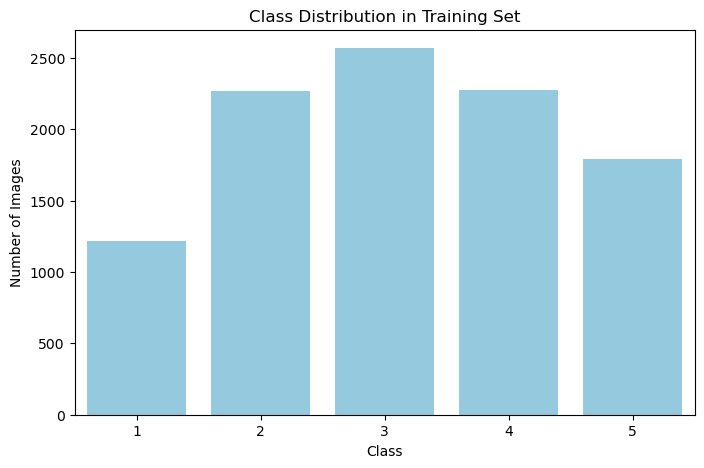

In [5]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Count images in each class for the training set
def count_images_in_train(data_dir='train'):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Get training class counts and plot
train_class_counts = count_images_in_train()

# Plot class distribution for the training set
plt.figure(figsize=(8, 5))
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.show()


## Display Image Sample

Samples from class 1:


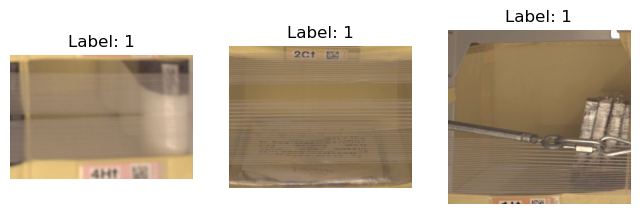

Samples from class 2:


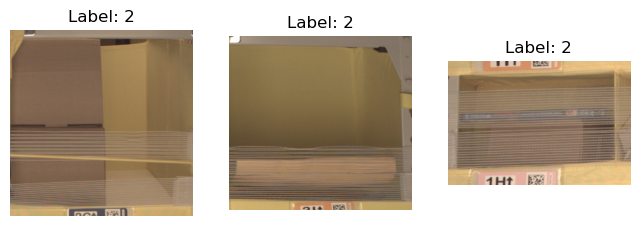

Samples from class 3:


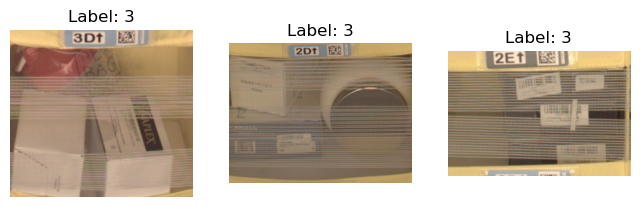

Samples from class 4:


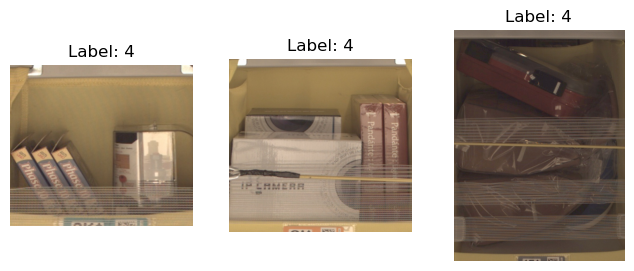

Samples from class 5:


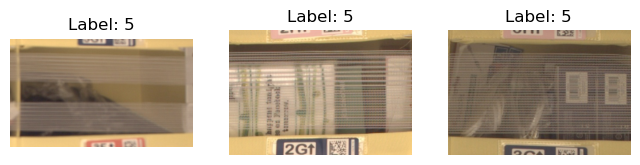

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

def display_samples(data_dir='train', num_samples=3):
    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            files = os.listdir(folder_path)
            print(f"Samples from class {label}:")
            
            plt.figure(figsize=(8, 3))
            for i in range(num_samples):
                file = random.choice(files)
                image_path = os.path.join(folder_path, file)
                image = Image.open(image_path)
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Label: {label}")
            plt.show()

# Display samples exclusively from the training dataset
display_samples('train')


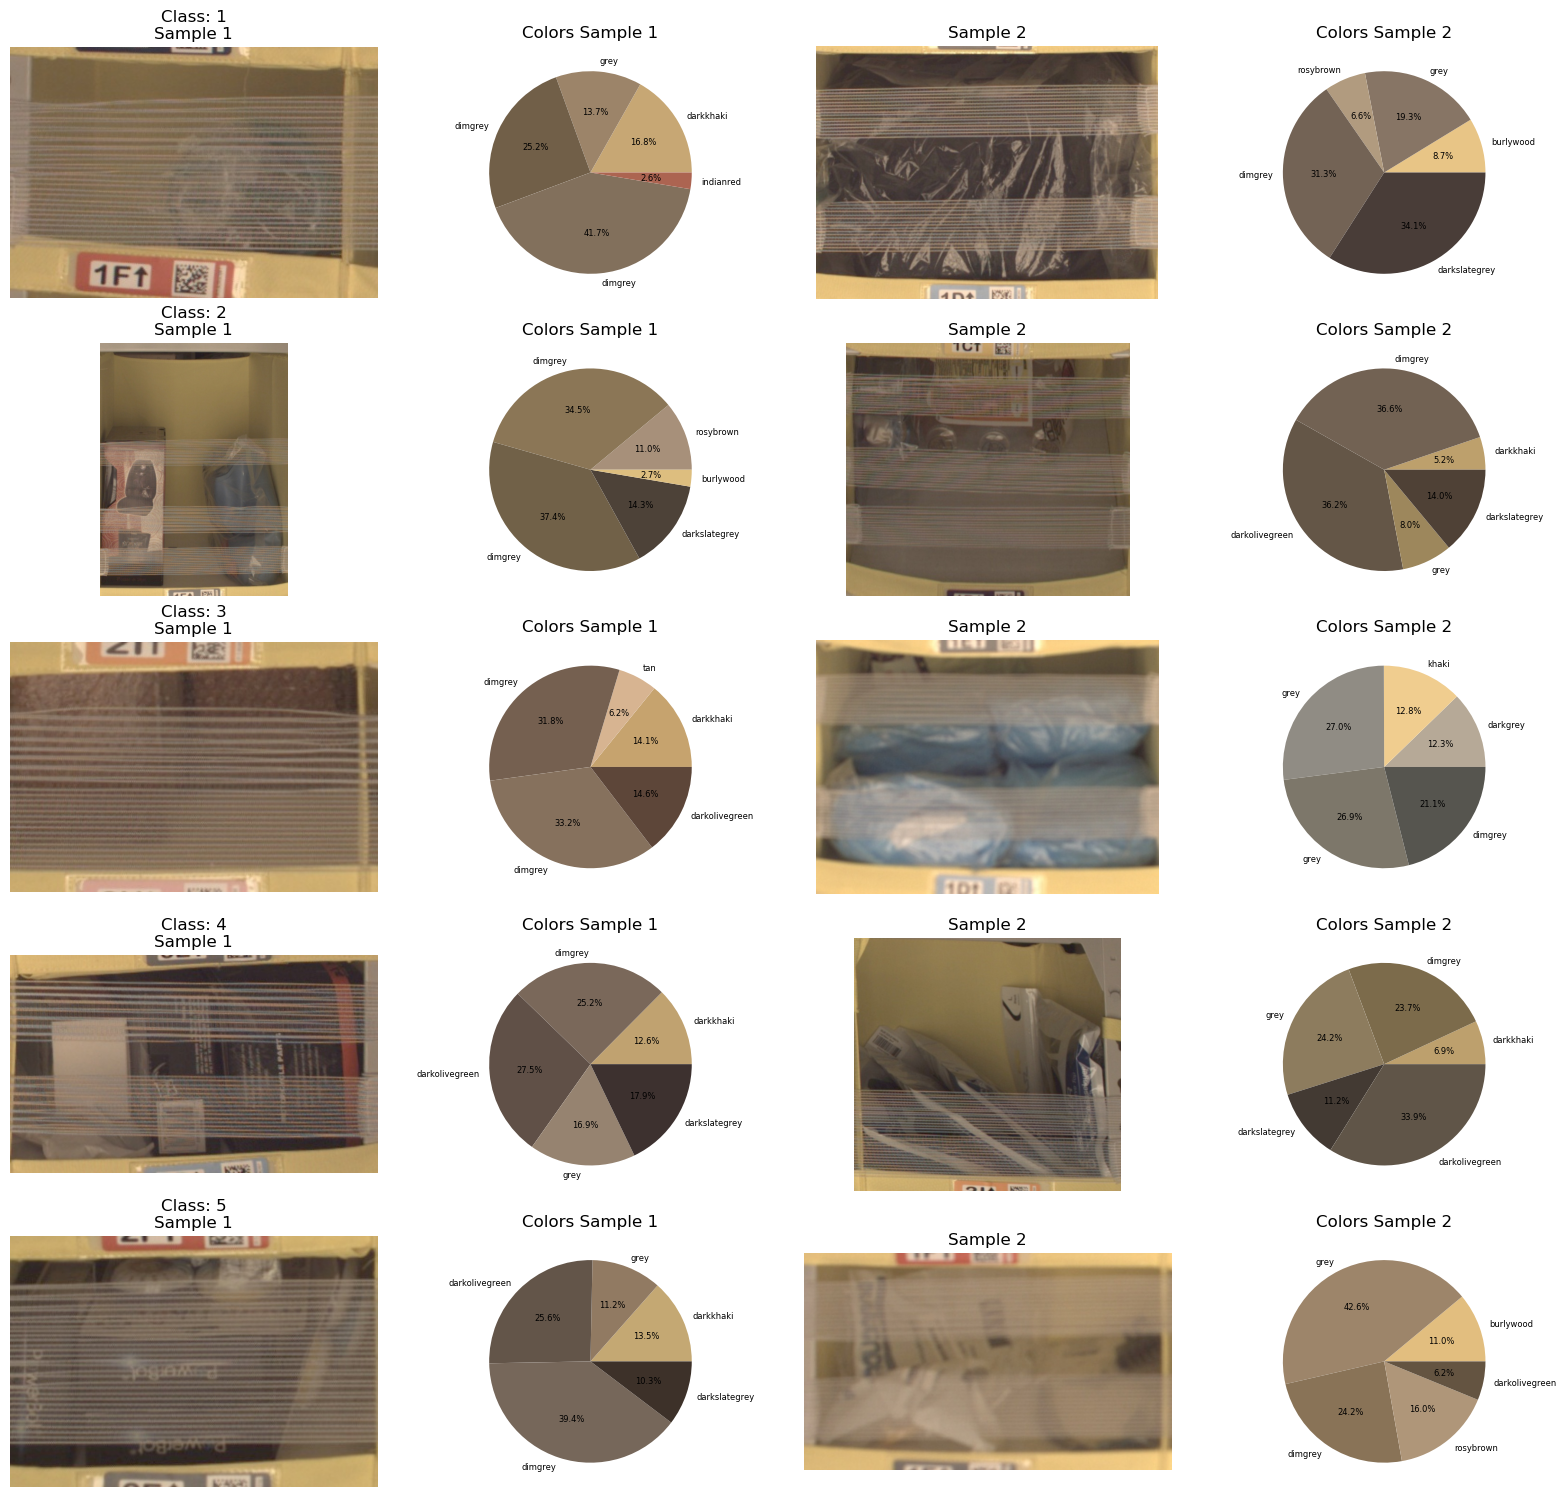

In [11]:
import os
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import webcolors

def closest_colour(requested_colour):
    """Find the closest CSS3 color name for an RGB value"""
    min_colours = {}
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def analyze_color_distribution(data_dir='train', samples_per_class=2, n_colors=5):
    """Analyze color distribution with sample images and their corresponding pie charts"""
    def get_dominant_colors(image_path):
        img = Image.open(image_path).convert('RGB')
        img = img.resize((100, 100))  # Smaller resize for faster processing
        pixels = np.float32(img).reshape(-1, 3)
        
        kmeans = KMeans(n_clusters=n_colors, random_state=42)
        kmeans.fit(pixels)
        colors = kmeans.cluster_centers_.astype(int)
        
        labels = kmeans.labels_
        counts = Counter(labels)
        percentages = {tuple(colors[i]): count/len(labels) * 100 
                      for i, count in counts.items()}
        return percentages

    # Count valid class directories
    class_dirs = [d for d in os.listdir(data_dir) 
                 if os.path.isdir(os.path.join(data_dir, d))]
    n_classes = len(class_dirs)
    
    # Create figure with compact layout
    # 4 columns per row: [image1][pie1][image2][pie2]
    plt.figure(figsize=(16, 3*n_classes))
    
    for idx, label in enumerate(sorted(class_dirs)):
        folder_path = os.path.join(data_dir, label)
        files = [f for f in os.listdir(folder_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if not files:
            continue
            
        # Select random samples
        selected_files = np.random.choice(files, 
                                        min(samples_per_class, len(files)), 
                                        replace=False)
        
        # Process each sample and its pie chart
        for i, file in enumerate(selected_files):
            image_path = os.path.join(folder_path, file)
            
            # Sample image subplot
            plt.subplot(n_classes, 4, idx*4 + 2*i + 1)
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            if i == 0:
                plt.title(f'Class: {label}\nSample {i+1}')
            else:
                plt.title(f'Sample {i+1}')
            
            # Get color distribution for this sample
            color_percentages = get_dominant_colors(image_path)
            
            colors = []
            percentages = []
            color_names = []
            
            for color, percentage in color_percentages.items():
                colors.append(np.array(color)/255)
                percentages.append(percentage)
                color_names.append(closest_colour(color))
            
            # Create pie chart for this sample
            ax_pie = plt.subplot(n_classes, 4, idx*4 + 2*i + 2)
            wedges, texts, autotexts = ax_pie.pie(percentages,
                                                 colors=colors,
                                                 autopct='%1.1f%%',
                                                 labels=color_names)
            
            plt.setp(autotexts, size=6)
            plt.setp(texts, size=6)
            plt.title(f'Colors Sample {i+1}')
    
    plt.tight_layout(pad=1.0)
    return plt

# Run the analysis
plt = analyze_color_distribution(samples_per_class=2, n_colors=5)
plt.show()

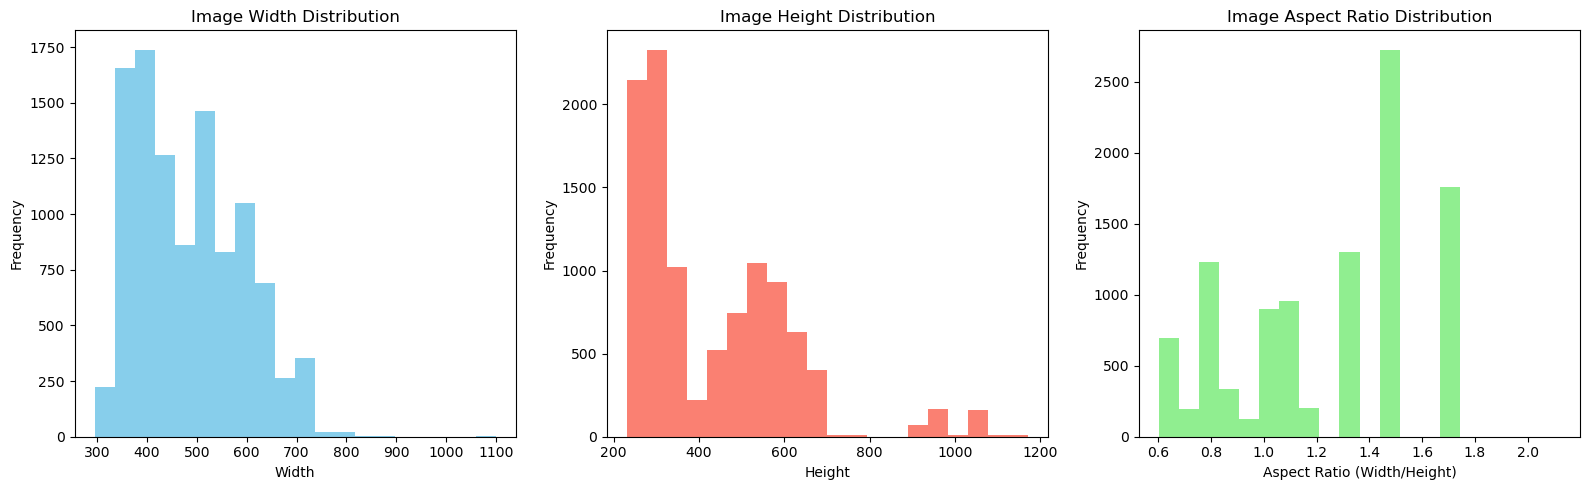

In [14]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define directory with images
data_dir = 'train_data'

# Lists to store dimensions
widths, heights, aspect_ratios = [], [], []

# Loop through each class folder and image
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_path) and not class_dir.startswith('.'):  # Skip hidden folders
        for img_file in os.listdir(class_path):
            if img_file.endswith(('.jpg', '.png', '.jpeg')):  # Check for image files
                img_path = os.path.join(class_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)
                        aspect_ratios.append(width / height)
                except Exception as e:
                    print(f"Error opening image {img_path}: {e}")

# Plot distributions
plt.figure(figsize=(16, 5))

# Width distribution
plt.subplot(1, 3, 1)
plt.hist(widths, bins=20, color='skyblue')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Image Width Distribution')

# Height distribution
plt.subplot(1, 3, 2)
plt.hist(heights, bins=20, color='salmon')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Image Height Distribution')

# Aspect ratio distribution
plt.subplot(1, 3, 3)
plt.hist(aspect_ratios, bins=20, color='lightgreen')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.title('Image Aspect Ratio Distribution')

plt.tight_layout()
plt.show()


The Amazon Bin Image Dataset has over 500,000 images of bins from Amazon Fulfillment Centers, taken during regular robotic operations. Each image shows a bin with a specific number of items, grouped by class (like bins with 1, 2, or more items). Most bins contain around 3 items, while bins with only 1 item are less common. Color analysis reveals a consistent pattern of muted warehouse colors, like dimgrey, dark olive green, and grey. However, packaging tape, similar wrapping, and items placed close together make it tough to clearly distinguish each object. The images come in different sizes, mostly between 400-600 pixels wide, with varying aspect ratios. This dataset is helpful for tasks like counting objects and managing inventory, helping build models to improve processes in fulfillment through automation and accurate detection. You can find more details in the Amazon Bin Image Dataset documentation.

## Upload to S3

In [56]:
!aws s3 sync train/ s3://udacity-cap/data/train/ --exclude "*/.ipynb_checkpoints/*"


In [57]:
!aws s3 sync valid/ s3://udacity-cap/data/valid/ --exclude "*/.ipynb_checkpoints/*"


In [58]:
!aws s3 sync test/ s3://udacity-cap/data/test/ --exclude "*/.ipynb_checkpoints/*"

### Hyperparameter Tuning

To optimize the training process, we set up a hyperparameter tuning job on SageMaker using the `HyperparameterTuner` class, targeting learning rate (`lr`), batch size (`batch_size`), and number of epochs (`epochs`)—all of which significantly impact model convergence and performance.

- **Learning Rate (`lr`)**: We chose a continuous range (0.001 to 0.1) to explore a broad spectrum of learning rates, as this parameter directly influences the speed and stability of training.
- **Batch Size (`batch_size`)**: Discrete options (32 to 512) were selected to balance between memory efficiency and gradient stability.
- **Epochs (`epochs`)**: A range of 10 to 40 was set to determine an optimal training duration without overfitting or underfitting.

The tuning job’s objective was to minimize the "Validation Loss" metric, parsed directly from training logs. After running five jobs sequentially, the best hyperparameters found were:
- `batch_size` of 32
- `epochs` of 21
- Learning rate (`lr`) of approximately 0.0023.


In [37]:
# Create your hyperparameter search space
# Example of hyperparameter search space
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
import sagemaker

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),  # Continuous range for learning rate
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),  # Discrete options for batch size
    "epochs": IntegerParameter(10, 40)  # Integer range for number of epochs
}

# Hyperparameter tuning setup (for minimizing loss)
objective_metric_name = "Validation Loss"  # This should match the metric name used in tuning.
objective_type = "Minimize"

# Metric definitions based on the output logs in hpo.py
metric_definitions = [
    {"Name": "Validation Loss", "Regex": "Valid Loss: ([0-9\\.]+)"}
]

In [39]:
# Create your training estimator
estimator = PyTorch(
    entry_point="hpo.py",                  # Training script for tuning
    source_dir="scripts",                  # Directory with the script
    role=sagemaker.get_execution_role(),   # SageMaker IAM role
    framework_version="1.8.0",             # PyTorch version
    py_version="py3",                      # Python version
    instance_count=1,                      # Number of instances per trial
    instance_type="ml.p2.xlarge",          # Instance type for tuning
    metric_definitions=metric_definitions # Metric definitions
)
# Set up the Hyperparameter Tuner
tuner = HyperparameterTuner(
    estimator=estimator,                    # Base estimator
    objective_metric_name=objective_metric_name, 
    objective_type=objective_type,
    metric_definitions=metric_definitions,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=5,                            # Total number of jobs to run
    max_parallel_jobs=1                     # Number of jobs to run in parallel
)

In [ ]:
# Start the hyperparameter tuning job
tuner.fit({"training": "s3://udacity-cap/data/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [48]:
# Get the best training job

# After tuning completes, retrieve best hyperparameters
best_training_job = tuner.best_training_job()
best_hyperparameters = tuner.best_estimator().hyperparameters()
best_hyperparameters_cleaned = {
    "batch_size": int(best_hyperparameters["batch_size"].strip('"')),
    "epochs": int(best_hyperparameters["epochs"].strip('"')),
    "lr": float(best_hyperparameters["lr"].strip('"'))
}
print("Best Hyperparameters:", best_hyperparameters_cleaned)



2024-11-04 10:05:35 Starting - Preparing the instances for training
2024-11-04 10:05:35 Downloading - Downloading the training image
2024-11-04 10:05:35 Training - Training image download completed. Training in progress.
2024-11-04 10:05:35 Uploading - Uploading generated training model
2024-11-04 10:05:35 Completed - Resource reused by training job: pytorch-training-241104-0724-003-bf694aad
Best Hyperparameters: {'batch_size': 32, 'epochs': 21, 'lr': 0.00228556219060162}


### Model Profiling and Debugging
Use model debugging and profiling to better monitor and debug the model training job.

In [45]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    ProfilerConfig,
    ProfilerRule,
    rule_configs,
    CollectionConfig,
    FrameworkProfile,
)

# Set debugging and profiling rules
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

# Set hook configuration for capturing specific data and metrics
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "5"
    },
    collection_configs=[
        CollectionConfig(
            name="CrossEntropyLoss_output_0",
            parameters={
                "include_regex": "CrossEntropyLoss_output_0",
                "train.save_interval": "10",
                "eval.save_interval": "1"
            }
        )
    ]
)

# Set profiler configuration for profiling system and framework metrics
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Model Training with the Best Hyperparameters
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [49]:
# Create the PyTorch estimator with debugging and profiling configurations
estimator = PyTorch(
    entry_point="train.py",                    # Your training script
    source_dir="scripts",                            # Directory with training script and dependencies
    role=role,                                 # IAM role with SageMaker permissions
    framework_version="1.8.0",                 # PyTorch version
    py_version="py3",                          # Python version
    instance_count=1,                          # Number of instances
    instance_type="ml.p3.2xlarge",             # Instance type
    debugger_hook_config=hook_config,          # Hook configuration
    rules=rules,                               # Debugging rules
    profiler_config=profiler_config,           # Profiler configuration
    hyperparameters=best_hyperparameters_cleaned,   # Use the best hyperparameters from tuning job
    output_path="s3://udacity-cap/output/",
)

# Specify S3 path for training data
train_data_path = "s3://udacity-cap/data/"

# Launch the training job with debugging and profiling configurations
estimator.fit({"training": train_data_path})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-11-04-22-31-49-026


2024-11-04 22:31:49 Starting - Starting the training job
2024-11-04 22:31:49 Pending - Training job waiting for capacity...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-11-04 22:32:48 Pending - Preparing the instances for training......
2024-11-04 22:33:48 Downloading - Downloading input data...
2024-11-04 22:34:16 Downloading - Downloading the training image..............................
2024-11-04 22:39:23 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-04 22:39:43,600 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-04 22:39:43,631 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-11-04 22:39

### Train Second Time

In [53]:

# S3 path where the previous model is stored
previous_model_s3_path = "s3://udacity-cap/output/pytorch-training-2024-11-04-22-31-49-026/output/model.tar.gz"


estimator = PyTorch(
    entry_point="train.py",
    source_dir="scripts",
    role=role,
    framework_version="1.8.0",
    py_version="py3",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    debugger_hook_config=hook_config,
    rules=rules,
    profiler_config=profiler_config,
    hyperparameters=best_hyperparameters_cleaned,
    output_path="s3://udacity-cap/output/",
    model_uri=previous_model_s3_path  # Use the path to the saved model
)

estimator.fit({"training": "s3://udacity-cap/data/"})


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-11-05-00-38-58-157


2024-11-05 00:38:58 Starting - Starting the training job
2024-11-05 00:38:58 Pending - Training job waiting for capacity...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-11-05 00:40:01 Pending - Preparing the instances for training...
2024-11-05 00:40:25 Downloading - Downloading input data...
2024-11-05 00:41:01 Downloading - Downloading the training image.................................
2024-11-05 00:46:27 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-05 00:46:48,693 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-05 00:46:48,726 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-11-05 00:46:

In [57]:
# Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-11-05 07:20:16.797 default:228 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-11-05 07:20:16.811 default:228 INFO s3_trial.py:42] Loading trial debug-output at path s3://udacity-cap/output/pytorch-training-2024-11-05-00-38-58-157/debug-output
[2024-11-05 07:20:17.578 default:228 WARNING s3handler.py:184] Encountered the exception [SSL] record layer failure (_ssl.c:2580) while reading s3://udacity-cap/output/pytorch-training-2024-11-05-00-38-58-157/debug-output/index/000000001/000000001117_worker_0.json . Will retry now


In [58]:
# List all available tensors
print("Available Tensors:", trial.tensor_names())

[2024-11-05 07:23:08.682 default:228 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-05 07:23:09.698 default:228 INFO trial.py:210] Loaded all steps
Available Tensors: ['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_inpu

In [61]:
estimator.latest_job_debugger_artifacts_path()

's3://udacity-cap/output/pytorch-training-2024-11-05-00-38-58-157/debug-output'

Loaded TRAIN data.
Loaded EVAL data.
Completed TRAIN plot.
Completed EVAL plot.


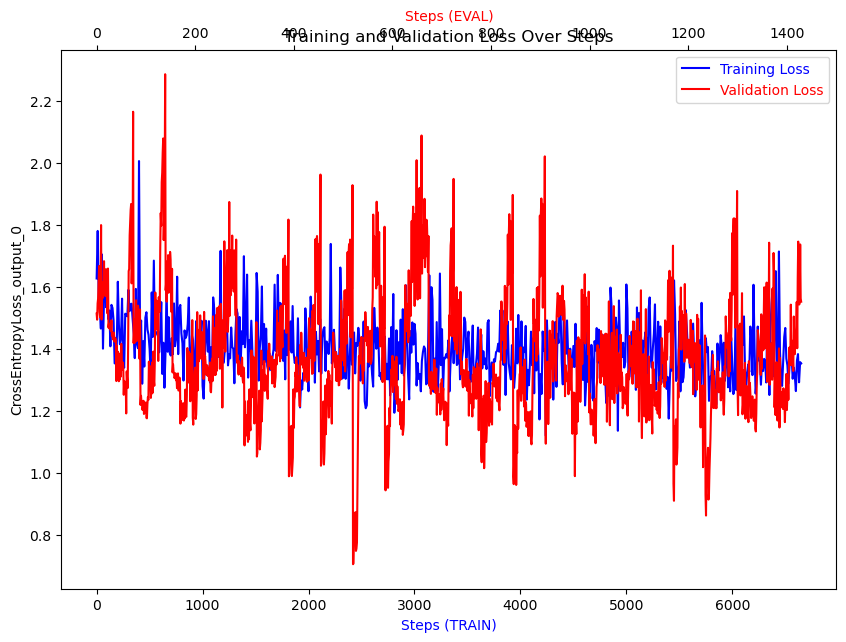

In [65]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import smdebug.pytorch as smd
from smdebug.trials import create_trial

# Ensure the 'results' directory exists
if not os.path.exists("results"):
    os.makedirs("results")

def get_data(trial, tensor_name, mode):
    """
    Retrieve steps and values for the specified tensor and mode (TRAIN/EVAL).
    """
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(s, mode=mode) for s in steps]
    return steps, vals

def plot_tensor(trial, tensor_name):
    """
    Plot tensor values for both training and validation modes.
    """
    # Retrieve data for training and validation
    steps_train, vals_train = get_data(trial, tensor_name, mode=smd.modes.TRAIN)
    print("Loaded TRAIN data.")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=smd.modes.EVAL)
    print("Loaded EVAL data.")

    # Plotting setup
    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)
    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    # Plot training and evaluation data
    (p1,) = host.plot(steps_train, vals_train, label="Training Loss", color='b')
    print("Completed TRAIN plot.")
    (p2,) = par.plot(steps_eval, vals_eval, label="Validation Loss", color='r')
    print("Completed EVAL plot.")
    
    # Legend and labeling
    leg = plt.legend()
    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())
    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.title("Training and Validation Loss Over Steps")
    plt.savefig('results/CrossEntropy_Loss_during_training_and_validation.png')
    plt.show()

# Specify the name of the tensor you want to plot
tensor_name = "CrossEntropyLoss_output_0"
plot_tensor(trial, tensor_name)


In [68]:
# Display the profiler output
# Step 1: Define the path to the rule output in S3
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

# Step 2: Print the path for reference
print(f"You will find the profiler report in {rule_output_path}")

# Step 3: Copy profiler report files from S3 to the local notebook
! aws s3 cp {rule_output_path} ./ --recursive

# Step 4: Get the profiler report folder name generated by SageMaker
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

# Step 5: Display the profiler report HTML in the notebook
import IPython
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")


You will find the profiler report in s3://udacity-cap/output/pytorch-training-2024-11-05-00-38-58-157/rule-output
download: s3://udacity-cap/output/pytorch-training-2024-11-05-00-38-58-157/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://udacity-cap/output/pytorch-training-2024-11-05-00-38-58-157/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://udacity-cap/output/pytorch-training-2024-11-05-00-38-58-157/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://udacity-cap/output/pytorch-training-2024-11-05-00-38-58-157/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.j

### Model Deploying and Querying
Set up the inference endpoint and randomly pick one image from each class in the source data website (Amazon Bin Image Dataset).

In [123]:
# Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

from PIL import Image
import io
import base64

In [124]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [125]:
model_location=estimator.model_data

pytorch_inference_model = PyTorchModel(
            entry_point="inference.py",
            source_dir="scripts",
            role=role,
            model_data=model_location,
            framework_version="1.9",
            py_version="py38",
            predictor_cls=ImagePredictor,
)

In [126]:
predictor = pytorch_inference_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large',
)

INFO:sagemaker:Repacking model artifact (s3://udacity-cap/output/pytorch-training-2024-11-05-00-38-58-157/output/model.tar.gz), script artifact (scripts), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-275370044919/pytorch-inference-2024-11-06-08-14-18-679/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-11-06-08-14-28-512
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-11-06-08-14-29-263
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-11-06-08-14-29-263


--------!

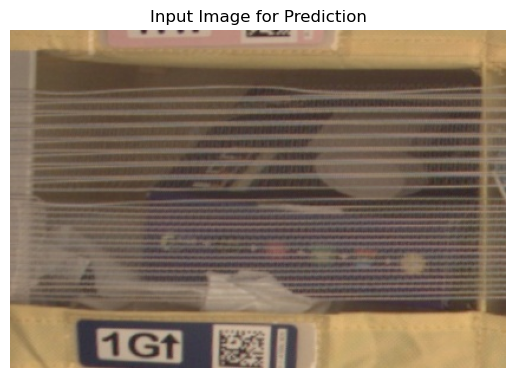

Prediction Response: {'predicted_class': 2, 'confidence': 0.32350680232048035}


In [133]:
# Run an prediction on the endpoint
from PIL import Image
import io
import matplotlib.pyplot as plt

def predict_image(image_path: str, predictor):
    """
    Loads an image, displays it, converts it to bytes, 
    and sends it to the SageMaker endpoint for prediction.
    
    Args:
    - image_path (str): Path to the image to predict.
    - predictor: SageMaker predictor object for the deployed model.
    
    Returns:
    - dict: Prediction response from the endpoint.
    """
    
    def image_to_byte_array(image: Image) -> bytes:
        """Convert an image to a byte array."""
        img_byte_array = io.BytesIO()
        image.save(img_byte_array, format="JPEG")
        return img_byte_array.getvalue()
    
    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")  # Turn off axis
    plt.title("Input Image for Prediction")
    plt.show()
    
    # Convert image to bytes
    image_bytes = image_to_byte_array(image)
    
    # Send image bytes to the endpoint for prediction
    response = predictor.predict(image_bytes)
    
    # Print the response
    print("Prediction Response:", response)
    
    return response

# Sample image for one object
image_path = "infer_images/1-12345.jpg"  # Update with your image path
response = predict_image(image_path, predictor)


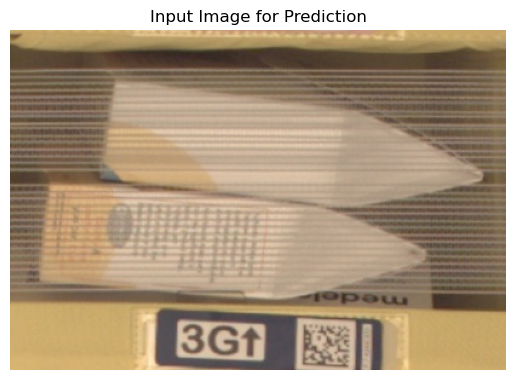

Prediction Response: {'predicted_class': 2, 'confidence': 0.33041974902153015}


In [134]:
# Sample image for two object
image_path = "infer_images/2-988.jpg"  # Update with your image path
response = predict_image(image_path, predictor)

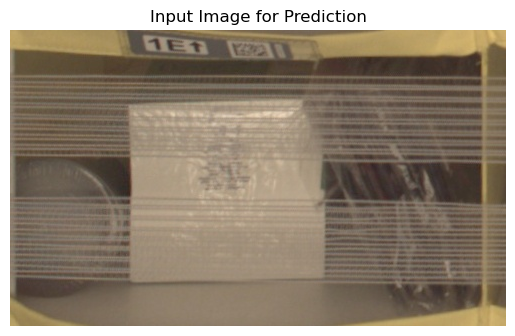

Prediction Response: {'predicted_class': 2, 'confidence': 0.34187960624694824}


In [135]:
# Sample image for three object
image_path = "infer_images/3-811.jpg"  # Update with your image path
response = predict_image(image_path, predictor)

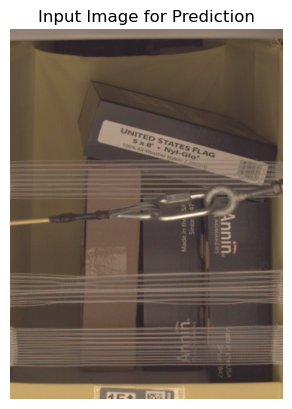

Prediction Response: {'predicted_class': 2, 'confidence': 0.38147592544555664}


In [136]:
# Sample image for four object
image_path = "infer_images/4-44849.jpg"  # Update with your image path
response = predict_image(image_path, predictor)

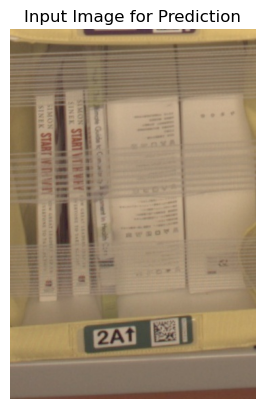

Prediction Response: {'predicted_class': 4, 'confidence': 0.5037984251976013}


In [137]:
# Sample image for five object
image_path = "infer_images/5-170169.jpg"  # Update with your image path
response = predict_image(image_path, predictor)

In [141]:
# Remember to shutdown/delete your endpoint once your work is done
# Once done, delete the endpoint to avoid incurring costs
predictor.delete_endpoint()
print(f"Deleted endpoint: {endpoint_name}")

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-11-06-08-14-29-263
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-11-06-08-14-29-263


Deleted endpoint: pytorch-inference-2024-11-06-07-43-24-308


### Multi-Instance Training

In [ ]:
# Train your model on Multiple Instances
from sagemaker.pytorch import PyTorch

# S3 path where the previous model is stored
previous_model_s3_path = "s3://udacity-cap/output/pytorch-training-2024-11-04-22-31-49-026/output/model.tar.gz"

# Modify the estimator for multi-instance training
estimator = PyTorch(
    entry_point="train.py",
    source_dir="scripts",
    role=role,
    framework_version="1.8.0",
    py_version="py3",
    instance_count=2,  # Set to 2 or more for multi-instance training
    instance_type="ml.m5.2xlarge",
    debugger_hook_config=hook_config,
    rules=rules,
    profiler_config=profiler_config,
    hyperparameters=best_hyperparameters_cleaned,
    output_path="s3://udacity-cap/output/",
    model_uri=previous_model_s3_path,
    distribution={
        "pytorchx": {
            "enabled": True  # Enable distributed training for PyTorch
        }
    }
)

# Start the training job
estimator.fit({"training": "s3://udacity-cap/data/"})


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-11-06-08-38-32-178


2024-11-06 08:38:32 Starting - Starting the training job...
2024-11-06 08:38:59 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-11-06 08:39:30 Downloading - Downloading input data...
2024-11-06 08:40:05 Downloading - Downloading the training image......
2024-11-06 08:41:00 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-06 08:40:58,035 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-06 08:40:58,038 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-11-06 08:40:58,054 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-

In [ ]:
estimator.logs()

2024-11-06 13:37:02 Starting - Preparing the instances for training
2024-11-06 13:37:02 Downloading - Downloading the training image
2024-11-06 13:37:02 Training - Training image download completed. Training in progress.
2024-11-06 13:37:02 Uploading - Uploading generated training model
2024-11-06 13:37:02 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-06 08:40:58,035 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-06 08:40:58,038 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-11-06 08:40:58,054 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-11-06 08:40:58,057 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-11-06 08:40:58,256 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
202